# Final Project Machine Learning

*By Basri Satiroglu, Daniel Deutsch and José Lucas Barretto.*

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import tensorflow as tf
from keras.callbacks import History
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tools.tools import pinv_extended
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

In [2]:
# Matplotlib styles
plt.style.use('ggplot')
plt.rcParams.update({
    'figure.figsize': (15, 4),
    'axes.prop_cycle': plt.cycler(color=["#4C72B0", "#C44E52", "#55A868", "#8172B2", "#CCB974", "#64B5CD"]),
    'axes.facecolor': "#EAEAF2"
})

# Problematic

Two-sided platforms are multi-sided platforms that connect two different but interdependent groups of customers. By connecting these groups, they add value as intermediaries. A number of examples of two-sided platforms exist, such as Netflix, Facebook, YouTube, etc., which, in very simplified terms, connect product consumers and product providers. Online shopping websites such as Amazon, Walmart, Mercado Livre, Rakouten, etc. are also considered two-sided platforms. Essentially, they connect product buyers and sellers through their user-friendly UI/UX. 

For the purposes of this project, we will focus on the example of Amazon. On every two-sided network we can analyse what we call network side effects. These are the consequences of the increment or decrease of providers or clients in the network. If, in the case of Amazon, for example, there are more product offers, the side-effects with regard to the sellers are rather negative, since there is now more competitive behaviour among them. At the same time, however, this side-effect benefits the clients, as the suppliers now compete for the optimum price and the clients can thus obtain the product at the best price. 

The same effect can be drawn on the clients. Even if there is a larger quantity of clients, there are no negative side-effects on them, as they do not compete with each other (in most of the cases). Among other things, this can also be attributed to the first hypothesis that the providers offer their products at the best price due to the competitive environment and that the clients are thus at an advantage. 

In the following, our work refers to what it means that an offer is the best offer and under which factors Amazon decides to refer to this offer as the best among all the other offers and to select and list it as the first on its website. In this way, we want to find out as to how it is possible for sellers to improve their offerings and to be listed first in Amazon's buy box. 

Furthermore, we want to deal with the verticalisation of Amazon's business model. While in a previous model Amazon linked the two edges, i.e. the sellers with the consumers, Amazon has been verticalising its model for some time now and offers its own products independently. Thus, in our work we also want to analyse to what extent Amazon could give themselves an unfair advantage by prioritising their own products and thus promoting more of their own products than in comparison to private sellers.

# Dataset

## About the Data

The dataset used in our analysis has the following structure:

| Index &nbsp; | Name               | Description                                 |
|--------------|:-------------------|--------------------------------------------:|
|  0           | `prod_asin`        | Amazon's identifier of the product          |
|  1           | `prod_condition`   | Condition of the product (new, used, ...)   |
|  2           | `prod_price`       | Price of the product (in USD)               |
|  3           | `seller_index`     | Position of the seller offer in the buy box |
|  4           | `seller_name`      | Name of the seller                          |
|  5           | `seller_rating`    | Rating of the seller $ \in [0, 5]$          |
|  6           | `seller_n_reviews` | Number of reviews that the seller has       |

It contains information about the buy box of each one of the products of the two first pages of results when searching for the following queries on the Amazon platform:

- Macbook Pro
- Dell Xps
- Webcam
- Playstation
- Joystick
- Gaming Headset
- Body Weight Scale
- Omega 3
- Body Lotion
- Carpet
- Lamp
- Silverware
- Telescope
- Weather Station
- Arduino
- Sunglasses
- T-shirt
- Purse
- Baseball Bat
- Basketball
- Punching Bag

It is important to say that this data was scraped in June of 2021, so for sure the dataset isn't up to date, but the results we may get from it still hold for the sample. Its also important to say that the data was collected as if someone was using the website from New York and without cookies in its computer (Amazon's results changes based on this informations about the user as they are known for using price steering in their platform).

In [3]:
# Loads the dataframe
df = pd.read_csv("./datasets/amzn.csv", index_col=0)

# Numericalize columns
df = df.apply(pd.to_numeric, errors='ignore')

df

,prod_asin,prod_condition,prod_price,seller_index,seller_name,seller_rating,seller_n_reviews
0,B01D8KOZF4,New,36.00,0.0,Amazon.com,96.0,13630.0
1,B01D8KOZF4,New,73.00,1.0,OUT-OF-THIS-WORLD-TREASURES-WORLDWIDE SHIPPING,92.0,193.0
2,B01D8KOZF4,Collectible,78.00,2.0,More,92.0,193.0
3,B01EWNUUUA,New,59.00,0.0,Amazon.com,96.0,13630.0
4,B01EWNUUUA,Used,55.00,1.0,Amazon Warehouse,NaN,NaN
...,...,...,...,...,...,...,...
7363,B092QQKXJ4,New,21.00,0.0,Amazon.com,100.0,10.0
7364,B092QQKXJ4,New,21.00,1.0,Harlanppme,100.0,2.0
7365,B088LLXMXY,New,27.00,0.0,Amazon.com,91.0,325.0
7366,B088LLXMXY,Used,9.16,1.0,More,NaN,NaN


## Data Processing

### Output Metric

It is of course problematic to the model if we just use the seller index as our y variable since there are products that only have one offer and products with more than 20. Therefore, it is necessery for us to create a metric able to represent "how close the offer is to being the first on the buy box". We decided, then, to implement the following metric:

$
    y = 1 - \frac{\text{seller index}}{\text{number of sellers of the product}}
$

Notice that this metric "inverts" the notion of the seller index, i.e. the closer the metric is to 1, the higher is the position of the seller in the buy box.

In [4]:
# Gets the number of sellers of each product
df['y'] = df.groupby('prod_asin')['seller_index'].transform('max') + 1

# Calculates y
df['y'] = 1 - df['seller_index'] / df['y']

df 

,prod_asin,prod_condition,prod_price,seller_index,seller_name,seller_rating,seller_n_reviews,y
0,B01D8KOZF4,New,36.00,0.0,Amazon.com,96.0,13630.0,1.000000
1,B01D8KOZF4,New,73.00,1.0,OUT-OF-THIS-WORLD-TREASURES-WORLDWIDE SHIPPING,92.0,193.0,0.666667
2,B01D8KOZF4,Collectible,78.00,2.0,More,92.0,193.0,0.333333
3,B01EWNUUUA,New,59.00,0.0,Amazon.com,96.0,13630.0,1.000000
4,B01EWNUUUA,Used,55.00,1.0,Amazon Warehouse,NaN,NaN,0.833333
...,...,...,...,...,...,...,...,...
7363,B092QQKXJ4,New,21.00,0.0,Amazon.com,100.0,10.0,1.000000
7364,B092QQKXJ4,New,21.00,1.0,Harlanppme,100.0,2.0,0.500000
7365,B088LLXMXY,New,27.00,0.0,Amazon.com,91.0,325.0,1.000000
7366,B088LLXMXY,Used,9.16,1.0,More,NaN,NaN,0.666667


### One Hot Encoding

The algorithms we are going to use need to be able to interpret the dataset. Because of that it is advantageous to perform one hot encoding in the column `prod_condition`.

In [5]:
# Performs one hot encoding in the prod_condition column
df = pd.concat([df, pd.get_dummies(df['prod_condition'])], axis=1)

# Renames the new columns
df.rename(columns={ 'Collectible': 'is_collectible', 'New': 'is_new', 'Open': 'is_open', 'Renewed': 'is_renewed', 'To': 'is_to', 'Used': 'is_used' }, inplace=True)

df

,prod_asin,prod_condition,prod_price,seller_index,seller_name,seller_rating,seller_n_reviews,y,is_collectible,is_new,is_open,is_renewed,is_to,is_used
0,B01D8KOZF4,New,36.00,0.0,Amazon.com,96.0,13630.0,1.000000,0,1,0,0,0,0
1,B01D8KOZF4,New,73.00,1.0,OUT-OF-THIS-WORLD-TREASURES-WORLDWIDE SHIPPING,92.0,193.0,0.666667,0,1,0,0,0,0
2,B01D8KOZF4,Collectible,78.00,2.0,More,92.0,193.0,0.333333,1,0,0,0,0,0
3,B01EWNUUUA,New,59.00,0.0,Amazon.com,96.0,13630.0,1.000000,0,1,0,0,0,0
4,B01EWNUUUA,Used,55.00,1.0,Amazon Warehouse,NaN,NaN,0.833333,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7363,B092QQKXJ4,New,21.00,0.0,Amazon.com,100.0,10.0,1.000000,0,1,0,0,0,0
7364,B092QQKXJ4,New,21.00,1.0,Harlanppme,100.0,2.0,0.500000,0,1,0,0,0,0
7365,B088LLXMXY,New,27.00,0.0,Amazon.com,91.0,325.0,1.000000,0,1,0,0,0,0
7366,B088LLXMXY,Used,9.16,1.0,More,NaN,NaN,0.666667,0,0,0,0,0,1


In our analysis we also intend to see if Amazon is gives itself advantages so, to facilitate its interpretation it is also interesting to add a column saying whether amazon is the seller of the product or not. This was done simply by selecting the `seller_name` that cointains the word amazon (case insensitive) in it (1 means that Amazon is the seller).

In [6]:
# Performs one hot encoding in the seller n
df['is_amazon'] = df['seller_name'].str.contains('amazon', case=False).replace({True: 1, False: 0})

df

,prod_asin,prod_condition,prod_price,seller_index,seller_name,seller_rating,seller_n_reviews,y,is_collectible,is_new,is_open,is_renewed,is_to,is_used,is_amazon
0,B01D8KOZF4,New,36.00,0.0,Amazon.com,96.0,13630.0,1.000000,0,1,0,0,0,0,1.0
1,B01D8KOZF4,New,73.00,1.0,OUT-OF-THIS-WORLD-TREASURES-WORLDWIDE SHIPPING,92.0,193.0,0.666667,0,1,0,0,0,0,0.0
2,B01D8KOZF4,Collectible,78.00,2.0,More,92.0,193.0,0.333333,1,0,0,0,0,0,0.0
3,B01EWNUUUA,New,59.00,0.0,Amazon.com,96.0,13630.0,1.000000,0,1,0,0,0,0,1.0
4,B01EWNUUUA,Used,55.00,1.0,Amazon Warehouse,NaN,NaN,0.833333,0,0,0,0,0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7363,B092QQKXJ4,New,21.00,0.0,Amazon.com,100.0,10.0,1.000000,0,1,0,0,0,0,1.0
7364,B092QQKXJ4,New,21.00,1.0,Harlanppme,100.0,2.0,0.500000,0,1,0,0,0,0,0.0
7365,B088LLXMXY,New,27.00,0.0,Amazon.com,91.0,325.0,1.000000,0,1,0,0,0,0,1.0
7366,B088LLXMXY,Used,9.16,1.0,More,NaN,NaN,0.666667,0,0,0,0,0,1,0.0


## Interesting Stats

### Simple Data Description

In [7]:
df.describe()

,prod_price,seller_index,seller_rating,seller_n_reviews,y,is_collectible,is_new,is_open,is_renewed,is_to,is_used,is_amazon
count,7283.000000,7368.000000,5659.000000,5.659000e+03,7368.000000,7368.000000,7368.000000,7368.000000,7368.000000,7368.000000,7368.000000,7245.000000
mean,129.590428,3.049674,88.915179,2.744411e+04,0.628732,0.001900,0.761536,0.008008,0.027552,0.003393,0.197204,0.346722
std,277.788603,2.966256,12.038345,9.889240e+04,0.300293,0.043552,0.426173,0.089132,0.163695,0.058155,0.397915,0.475959
min,1.710000,0.000000,0.000000,1.000000e+00,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,21.000000,0.000000,84.000000,1.650000e+02,0.363636,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,39.000000,2.000000,92.000000,1.479000e+03,0.636364,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,99.000000,5.000000,97.000000,8.695000e+03,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,3399.000000,10.000000,100.000000,1.086661e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Histogram Product Conditions

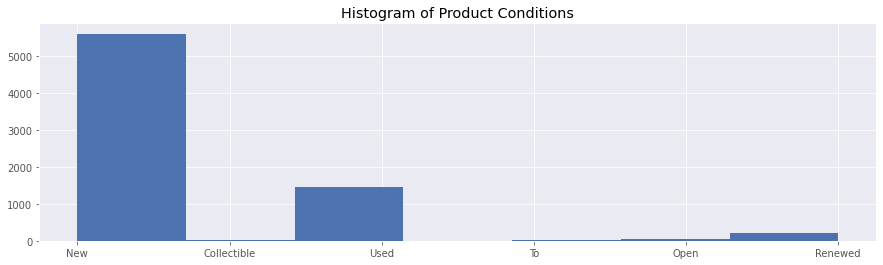

In [8]:
# Obtains the number of bins for the histogram
nbins = len(df['prod_condition'].unique())

# Plots the histogram
df['prod_condition'].hist(bins=nbins)
plt.title("Histogram of Product Conditions")
plt.show()

From the histogram above we can observe that most of the product offers in the dataset correspond to new products, followed by used ones. We can conclude that in this feature the dataset itself is very unbalanced.

### Histogram of Sellers

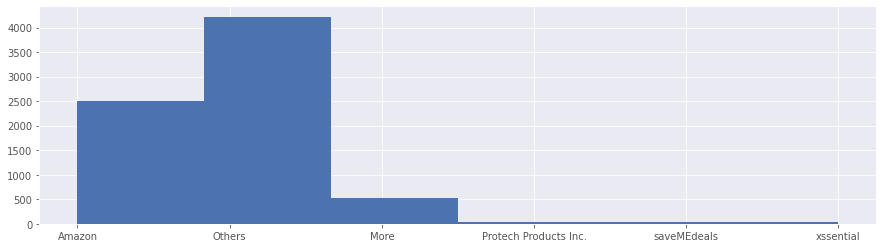

In [9]:
# Considers all Amazon 
df['seller_name_top_n'] = ['Amazon' if 'amazon' in str(seller_name).lower() else seller_name for seller_name in df['seller_name']]

# Obtains top n sellers names
n = 5
top_sellers = df['seller_name_top_n'].value_counts()[:n].index.tolist()

# Builds column with top n sellers and names the remaining as others
df['seller_name_top_n'] = [seller_name if seller_name in top_sellers else 'Others' for seller_name in df['seller_name_top_n']]

# Plots the histogram
df['seller_name_top_n'].hist(bins=n+1)
plt.show()

From the histogram above we can observe that Amazon is by far the seller that offers the most variety of products in the collect samples. The bar `Others`, represent the number of product offers from all the sellers that are not in the top 5.

# Models

Once we know some characteristics of the data we are considering to use in our analysis, we can start to build our models. The goal of these analysis is to understand which features are important for Amazon's decision (i.e. order) of product buy-box.

At first, we plan to explore the differences between a simple OLS, and regressions with Ridge and Lasso regularizations. Later on we build a simple neural network and a random forest regression if they perform better than the previous models.

Before we begin building our models, we first split the dataset between train and test sets, select the considered features and scale the data using the MinMaxScaler.

In [10]:
# Drops not available infos
df.dropna(inplace=True)

# List of features
features = ['prod_price', 'seller_rating', 'seller_n_reviews', 'is_collectible', 'is_new', 'is_open', 'is_renewed', 'is_to', 'is_used', 'is_amazon']

# Separates the df into input (X) and output (y) matrices
X = df[features]
y = df['y']

# Separates the data in train and test sets (test should be 20% of total)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print(f"Size of the training set: {X_train.shape[0]}")
print(f"Size of the test set: {X_test.shape[0]}")

# Center and standarize the train and test covariates
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Creates a results dataframes for comparison
df_results = pd.DataFrame()

Size of the training set: 4466
Size of the test set: 1117


### Auxiliary Functions

Here we created a few functions that returns metrics that enables us to compare all the models we build.

- `R2`: is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model.
- `MSE`: mean squared error provides a notion about how far the predicted values are from the true ones.
- `seller_indexes_correlation`: it is a metric created by us. It shows how close the predicted indexes are to the true ones.

In [11]:
def R2(y_true, y_pred):
    """Returns the determination coefficient (R^2) given the labels predictions and true values.

    Args:
        y_true (nparray): true value of labels.
        y_pred (nparray): predicted values of labels.

    Returns:
        float: Determination Coefficient
    """
    RSS = ((y_true-y_pred)**2).sum()          # Residual Sum of Squares 
    TSS = ((y_true-y_true.mean())**2).sum()   # Total Sum of Squares
    r2 = 1 - RSS/TSS                          # Determination Coefficient
    return r2


def MSE(y_true, y_pred):
    """Returns the mean squared error (MSE) given the labels predictions and true values.

    Args:
        y_true (nparray): true value of labels.
        y_pred (nparray): predicted values of labels.

    Returns:
        float: mean squared error (MSE)
    """
    mse = ((y_pred-y_true)**2).mean(axis=0)
    return mse


def seller_indexes_correlation(df, y_pred):
    """Returns the correlation between the predicted seller indexes and the adjusted ones.

    Args:
        df (pd.DataFrame): DataFrame with the whole dataset
        y_pred (pd.Series): Series with the predicted y

    Returns:
        [float]: Correlation between predicteed indexes and adjusted ones.
    """
    # Only considers the rows that are in y_pred
    df_tmp = pd.merge(df, y_pred.rename('y_pred'), left_index=True, right_index=True)
    
    # Since some of the rows were dropped, there are some products whose lowest seller index offer isn't 0, so we adjust that
    df_tmp['adj_seller_index'] = df_tmp.sort_values('seller_index', ascending=True).groupby('prod_asin').cumcount()
    
    # We reverse our previously made metric to obtain the seller index
    df_tmp['pred_seller_index'] = df_tmp.sort_values('y_pred', ascending=False).groupby('prod_asin').cumcount()

    # Returns the correlation between the adjusted and the prediction
    return df_tmp['adj_seller_index'].corr(df_tmp['pred_seller_index'])


### Benchmark model: OLS

In this section we simply do an OLS regression using our previously made metric as the independent variable to understand which features are significant for the selction of the buy box.

In [12]:
# Creates a model with the training data
model = sm.OLS(y_train, X_train)   # Creates the model
model_fit = model.fit()            # Fits the model

print(model_fit.summary(xname=features))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.510
Model:                            OLS   Adj. R-squared:                  0.509
Method:                 Least Squares   F-statistic:                     662.7
Date:                Sun, 23 Jan 2022   Prob (F-statistic):               0.00
Time:                        19:26:47   Log-Likelihood:                 424.41
No. Observations:                4466   AIC:                            -832.8
Df Residuals:                    4458   BIC:                            -781.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
prod_price        3.109e-06   1.35e-05  

In [13]:
# Predicts y_test using the model_fit and X_test as input
y_pred = model_fit.predict(X_test)

# Obtains the R^2 and the mse of the test data
r2 = R2(y_test, y_pred)
mse = MSE(y_test, y_pred)
corr = seller_indexes_correlation(df, y_pred)

# Adds the results to df_results
df_results = df_results.append(pd.DataFrame({'method': ['OLS'], 'R2': [r2], 'MSE': [mse], 'correlation': corr}), ignore_index=True)

print(f"For the test data using OLS we have: R^2={r2:.5f}, MSE={mse:.5f} and correlation: {corr:.5f}")

For the test data using OLS we have: R^2=0.50785, MSE=0.04855 and correlation: 0.62449


### Challenger Model I: Ridge

In this section we implement a linear regression with Ridge regularization to averiguate if it performs better on the dataset and/or gives us the same result as the OLS. Notice that we implement also a cross validation regarding the alpha parameter (which ranges in the interval $[0.001, 10]$) based on the AIC metric.

In [14]:
# Cross validates the alpha based on the AIC
best_model_fit, best_aic, best_alpha = None, None, None
for alpha in np.logspace(-3, 1, 100):

    # Creates a model with the training data
    model = sm.OLS(y_train, X_train)                          # Creates the model
    model_fit = model.fit_regularized(alpha=alpha, L1_wt=0)   # Fits the model

    # Obtains the normalized cov params for building the summary
    pinv_wexog, _ = pinv_extended(model.wexog)
    normalized_cov_params = np.dot(pinv_wexog, np.transpose(pinv_wexog))

    # Obtains the results
    r = sm.regression.linear_model.OLSResults(model, model_fit.params, normalized_cov_params)

    # Makes sure that it works on the first iteration
    if not best_aic:
        best_model_fit = model_fit
        best_aic = r.aic
        best_alpha = alpha

    # Updates the best model based on the AIC
    if r.aic < best_aic:
        best_model_fit = model_fit
        best_aic = r.aic
        best_alpha = alpha

# Obtains the normalized cov params for building the summary of the best model
pinv_wexog, _ = pinv_extended(model.wexog)
normalized_cov_params = np.dot(pinv_wexog, np.transpose(pinv_wexog))

# Obtains the results of the best model
r = sm.regression.linear_model.OLSResults(model, best_model_fit.params, normalized_cov_params)

print(f"The chosen alpha was {best_alpha}")
print(r.summary())

The chosen alpha was 0.001
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                     659.3
Date:                Sun, 23 Jan 2022   Prob (F-statistic):               0.00
Time:                        19:26:48   Log-Likelihood:                 418.62
No. Observations:                4466   AIC:                            -821.2
Df Residuals:                    4458   BIC:                            -770.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
prod_price   

c:\Users\Dell\Desktop\Code\FTD\Scoring and ML\project\venv\lib\site-packages\statsmodels\regression\linear_model.py:1917: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(eigvals[0]/eigvals[-1])


In [15]:
# Predicts y_test using the model_fit and X_test as input
y_pred = best_model_fit.predict(X_test)

# Obtains the R^2 and the mse of the test data
r2 = R2(y_test, y_pred)
mse = MSE(y_test, y_pred)
corr = seller_indexes_correlation(df, y_pred)

# Adds the results to df_results
df_results = df_results.append(pd.DataFrame({'method': ['Ridge'], 'R2': [r2], 'MSE': [mse], 'correlation': corr}), ignore_index=True)

print(f"For the test data using Ridge we have: R^2={r2:.5f}, MSE={mse:.5f} and correlation: {corr:.5f}")

For the test data using Ridge we have: R^2=0.50523, MSE=0.04881 and correlation: 0.63519


### Challenger Model II: Lasso

In this section we implement a linear regression with Lasso regularization to averiguate if it performs better on the dataset and/or gives us the same result as the OLS. Notice that we implement also a cross validation regarding the alpha parameter (which ranges in the interval $[0.001, 10]$) based on the AIC metric.

In [16]:
# Cross validates the alpha based on the AIC
best_model_fit, best_aic, best_alpha = None, None, None
for alpha in np.logspace(-3, 1, 100):

    # Creates a model with the training data
    model = sm.OLS(y_train, X_train)                          # Creates the model
    model_fit = model.fit_regularized(alpha=alpha, L1_wt=1)   # Fits the model

    # Obtains the normalized cov params for building the summary
    pinv_wexog, _ = pinv_extended(model.wexog)
    normalized_cov_params = np.dot(pinv_wexog, np.transpose(pinv_wexog))

    # Obtains the results
    r = sm.regression.linear_model.OLSResults(model, model_fit.params, normalized_cov_params)

    # Makes sure that it works on the first iteration
    if not best_aic:
        best_model_fit = model_fit
        best_aic = r.aic
        best_alpha = alpha

    # Updates the best model based on the AIC
    if r.aic < best_aic:
        best_model_fit = model_fit
        best_aic = r.aic
        best_alpha = alpha

# Obtains the normalized cov params for building the summary of the best model
pinv_wexog, _ = pinv_extended(model.wexog)
normalized_cov_params = np.dot(pinv_wexog, np.transpose(pinv_wexog))

# Obtains the results of the best model
r = sm.regression.linear_model.OLSResults(model, best_model_fit.params, normalized_cov_params)

print(f"The chosen alpha was {best_alpha}")
print(r.summary())

The chosen alpha was 0.001
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.495
Method:                 Least Squares   F-statistic:                     626.9
Date:                Sun, 23 Jan 2022   Prob (F-statistic):               0.00
Time:                        19:26:54   Log-Likelihood:                 362.00
No. Observations:                4466   AIC:                            -708.0
Df Residuals:                    4458   BIC:                            -656.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
prod_price   

c:\Users\Dell\Desktop\Code\FTD\Scoring and ML\project\venv\lib\site-packages\statsmodels\regression\linear_model.py:1917: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(eigvals[0]/eigvals[-1])


In [17]:
# Predicts y_test using the model_fit and X_test as input
y_pred = best_model_fit.predict(X_test)

# Obtains the R^2 and the mse of the test data
r2 = R2(y_test, y_pred)
mse = MSE(y_test, y_pred)
corr = seller_indexes_correlation(df, y_pred)

# Adds the results to df_results
df_results = df_results.append(pd.DataFrame({'method': ['Lasso'], 'R2': [r2], 'MSE': [mse], 'correlation': corr}), ignore_index=True)

print(f"For the test data using Lasso we have: R^2={r2:.5f}, MSE={mse:.5f} and correlation: {corr:.5f}")

For the test data using Lasso we have: R^2=0.48788, MSE=0.05052 and correlation: 0.57742


### Challenger Model III: Neural Network

Now, we implement a simple neural network with to check the results. This NN consists in 4 fully connected hidden layers with ReLu activation functions and uses the MSE as its loss function.

In [18]:
# Instantiates the network
model = keras.Sequential()

# Builds the model network structure
model.add(layers.Dense(100, input_dim=len(features)))
model.add(layers.ReLU())
model.add(layers.Dense(200))
model.add(layers.ReLU())
model.add(layers.Dense(200))
model.add(layers.ReLU())
model.add(layers.Dense(100))
model.add(layers.Dense(1, activation='sigmoid'))

# Compiles the network
adam = Adam(learning_rate=0.000001)
model.compile(loss='mean_squared_error', optimizer=adam)

# Trains the network
history = History()
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), validation_freq=1, batch_size=10, verbose=0)


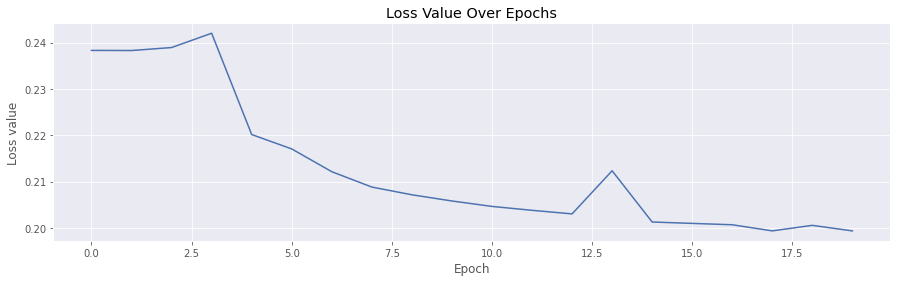

In [19]:
# Plots the loss (MSE) over epochs
plt.plot(np.arange(len(history.history["loss"])), history.history["loss"])
plt.title("Loss Value Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss value")
plt.show()

In [20]:
# Predicts y_test using the model_fit and X_test as input
y_pred = model.predict(X_test).flatten()
y_pred = pd.Series(y_pred, y_test.index)

# Obtains the R^2 and the mse of the test data
r2 = R2(y_test, y_pred)
mse = MSE(y_test, y_pred)
corr = seller_indexes_correlation(df, y_pred)

# Adds the results to df_results
df_results = df_results.append(pd.DataFrame({'method': ['Neural Network'], 'R2': [r2], 'MSE': [mse], 'correlation': corr}), ignore_index=True)

print(f"For the test data using NN we have: R^2={r2:.5f}, MSE={mse:.5f} and correlation: {corr:.5f}")

For the test data using NN we have: R^2=-1.12596, MSE=0.20974 and correlation: 0.54747


### Challenger Model IV: Random Forest

Finally, we implement a simple random forest regression with 100 trees in it, using the mean squared error as its criterion.

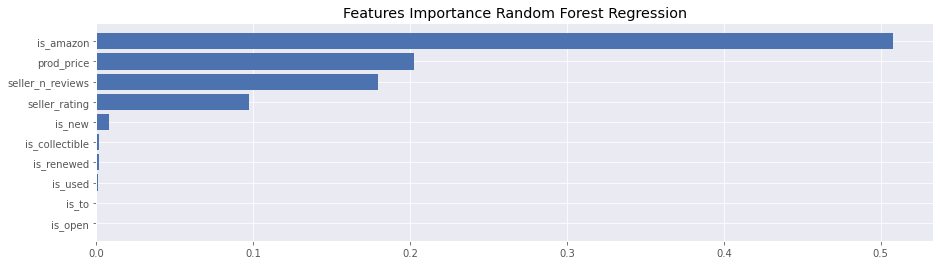

In [21]:
# Creates a model with the training data
model = RandomForestRegressor(random_state=0)   # Creates the model
model_fit = model.fit(X_train, y_train)         # Fits the model

# Plots the importance of the features
sorted_indexes = model_fit.feature_importances_.argsort()
plt.barh([features[i] for i in sorted_indexes], model_fit.feature_importances_[sorted_indexes])
plt.title("Features Importance Random Forest Regression")
plt.show()

In [22]:
# Predicts y_test using the model_fit and X_test as input
y_pred = model_fit.predict(X_test).flatten()
y_pred = pd.Series(y_pred, y_test.index)

# Obtains the R^2 and the mse of the test data
r2 = R2(y_test, y_pred)
mse = MSE(y_test, y_pred)
corr = seller_indexes_correlation(df, y_pred)

# Adds the results to df_results
df_results = df_results.append(pd.DataFrame({'method': ['Random Forest'], 'R2': [r2], 'MSE': [mse], 'correlation': corr}), ignore_index=True)

print(f"For the test data using NN we have: R^2={r2:.5f}, MSE={mse:.5f} and correlation: {corr:.5f}")

For the test data using NN we have: R^2=0.56031, MSE=0.04338 and correlation: 0.75608


# Result Analysis

When comparing the performance of the implemented models, keeping our goal in mind, the most relevant metric to be analyzed is the correlation between the predicted seller indexes and the adjusted indexes (shown in the third column of the table below). The closer this value is to one, the better the model predicts the seller position in the buy box.

In [23]:
df_results

,method,R2,MSE,correlation
0,OLS,0.507849,0.048554,0.624494
1,Ridge,0.505235,0.048812,0.635192
2,Lasso,0.487879,0.050524,0.577422
3,Neural Network,-1.125960,0.209742,0.547467
4,Random Forest,0.560313,0.043378,0.756082


As one can conclude from the result table above, the model that best predicted the seller index in the buy box is the Random Forest Regression, followed by the Ridge, OLS, Lasso and Neural Net.

It is interesting to see, though, the neural network in the last place of the podium, as it has the most complext architecture behind its curtains. The obtained result though, could be improved by changing the structure of the neural net, adding layers, neurons, changing activation functions, decreasing the learning rate and increasing the epochs or even implementing some other techniques such as early stop, dropout, etc.

Considering, firstly, only the Random Forest Regression Model we can analyse the features importance. Its important to say that the feature importance, in the random forest regression context, is a measure of how each feature decrease the impurity of the split (the feature with highest decrease is selected for internal node). Thus, one can see, from the feature importance plot, that the most important attribute when it comes to ordering Amazon's product buy-box is whether the seller is Amazon or not. Later on we have product price, number of reviews that the seller has and its global rating followed by whether the product condition is new or not.

For other models, the feature importance obtained (here seen as the significance and module of each one of the coefficients in the OLS, Ridge, or Lasso regressions) is quite similar. The biggest differences for the OLS and Ridge models would be it not considering product price and number of seller reviews as significant. For the Lasso, in the other hand, only the number of seller reviews significance substantially differs from the ones obtained in the random forest regression.

From a business point of view, if we consider the results obtained from the random forest regression model, we can see that this attempt of business verticalization from Amazon's part is very harmful for other sellers as the results show that Amazon tends to prioritize its offers in the buy-box. We can also see that offers with better prices also tend to have better positions in the buy-box and the same goes for sellers with higher reputation (i.e. higher amount of reviews and ratings). 

This way, if we consider a context where this small sample from Amazon's database fully explains the truth of what is behind Amazon's buy-box selection (which is obviosly not the case), for a small seller to succeed in selling its products in the platform, he/she should aim for products not yet sold by Amazon and try to give the best price possible (comparing with its competitors), trying to build and increase its reputation on the platform.